In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pickle
import keras_tuner as kt

In [2]:
industries = {
    'agro': ['CPF.BK', 'CBG.BK', 'OSP.BK', 'ITC.BK', 'BTG.BK'],
    'consump': ['AURA.BK', 'STGT.BK', 'BLC.BK', 'SNPS.BK', 'SABINA.BK'],
    'fincial': ['KBANK.BK', 'KTB.BK', 'SCB.BK', 'BBL.BK', 'TISCO.BK'],
    'indus': ['PTTGC.BK', 'SCGP.BK', 'IVL.BK', 'MCS.BK', 'TSTH.BK'],
    'propcon': ['SCC.BK', 'CPN.BK', 'WHA.BK', 'TOA.BK', 'AP.BK'],
    'resource': ['PTTEP.BK', 'BCP.BK', 'PTT.BK', 'TOP.BK', 'GPSC.BK'],
    'service': ['CPALL.BK', 'AOT.BK', 'BDMS.BK', 'HMPRO.BK', 'MINT.BK'],
    'tech': ['ADVANC.BK', 'TRUE.BK', 'DELTA.BK', 'CCET.BK', 'KCE.BK']
}

def create_sequences(data, sequence_length=60):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, 0])
        y.append(data[i, 0])
    return np.array(X).reshape(-1, sequence_length, 1), np.array(y)

def build_model(input_shape, lstm_units=50, dense_units=25, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=dense_units))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def run_tuner(x_train, y_train, input_shape, project_name):
    def model_builder(hp):
        return build_model(
            input_shape=input_shape,
            lstm_units=hp.Choice('lstm_units', [32, 64, 100, 128]),
            dropout_rate=hp.Choice('dropout_rate', [0.1, 0.2, 0.3]),
            dense_units=hp.Choice('dense_units', [16, 25, 50])
        )

    tuner = kt.RandomSearch(
        model_builder,
        objective='val_loss',
        max_trials=3,
        executions_per_trial=1,
        directory='tuning_logs',
        project_name=project_name
    )

    tuner.search(x_train, y_train, validation_split=0.2, epochs=30,
                 batch_size=32, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

    best_model = tuner.get_best_models(1)[0]
    best_hp = tuner.get_best_hyperparameters(1)[0]
    return best_model, best_hp

In [3]:
# Generate tuner per industry
industry_configs = {}

for industry, stocks in industries.items():
    base_stock = stocks[0]
    print(f"\n🎯 Tuning industry config for {industry} using {base_stock}...")

    data_path = os.path.join("data", industry, f"{base_stock}.csv")
    df = pd.read_csv(data_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df = df[['Close']]

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)
    train_data, _ = train_test_split(scaled_data, train_size=0.8, shuffle=False)
    x_train, y_train = create_sequences(train_data)

    best_model, best_hp = run_tuner(x_train, y_train, input_shape=(x_train.shape[1], 1), project_name=f"{industry}_baseline")
    industry_configs[industry] = {
        'lstm_units': best_hp.get('lstm_units'),
        'dropout_rate': best_hp.get('dropout_rate'),
        'dense_units': best_hp.get('dense_units')
    }
    print(f"✅ Best config for {industry}: {industry_configs[industry]}")

Trial 3 Complete [00h 00m 22s]
val_loss: 0.00047763032489456236

Best val_loss So Far: 0.00037706168950535357
Total elapsed time: 00h 01m 23s
✅ Best config for tech: {'lstm_units': 32, 'dropout_rate': 0.1, 'dense_units': 25}


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 28 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [4]:
industry_configs

{'agro': {'lstm_units': 128, 'dropout_rate': 0.2, 'dense_units': 16},
 'consump': {'lstm_units': 128, 'dropout_rate': 0.1, 'dense_units': 25},
 'fincial': {'lstm_units': 100, 'dropout_rate': 0.2, 'dense_units': 25},
 'indus': {'lstm_units': 100, 'dropout_rate': 0.3, 'dense_units': 50},
 'propcon': {'lstm_units': 128, 'dropout_rate': 0.2, 'dense_units': 50},
 'resource': {'lstm_units': 100, 'dropout_rate': 0.1, 'dense_units': 16},
 'service': {'lstm_units': 100, 'dropout_rate': 0.3, 'dense_units': 16},
 'tech': {'lstm_units': 32, 'dropout_rate': 0.1, 'dense_units': 25}}

In [6]:
# train all the stocks using tuner for each industry
for industry, stocks in industries.items():
    for stock in stocks:
        print(f"\n📦 Training model for {stock} using {industry} config")

        data_file = os.path.join("data", industry, f"{stock}.csv")
        if not os.path.exists(data_file):
            print(f"⚠️ File not found: {data_file}")
            continue

        df = pd.read_csv(data_file)
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
        df = df[['Close']]

        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(df)
        train_data, test_data = train_test_split(scaled_data, train_size=0.8, shuffle=False)

        if len(test_data) < 60:
            print(f"⚠️ Not enough test data for {stock}. Skipping...")
            continue

        x_train, y_train = create_sequences(train_data)
        x_test, y_test = create_sequences(test_data)

        if len(x_train) == 0 or len(x_test) == 0:
            print(f"⚠️ No sequences generated for {stock}. Skipping...")
            continue

        config = industry_configs[industry]
        model = build_model(
            input_shape=(x_train.shape[1], 1),
            lstm_units=config['lstm_units'],
            dropout_rate=config['dropout_rate'],
            dense_units=config['dense_units']
        )

        model_dir = os.path.join("models", industry)
        os.makedirs(model_dir, exist_ok=True)
        model_file = os.path.join(model_dir, f"{stock}_model.keras")
        scaler_file = os.path.join(model_dir, f"{stock}_scaler.pkl")

        early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
        model_checkpoint = ModelCheckpoint(model_file, monitor='loss', save_best_only=True)

        model.fit(
            x_train, y_train,
            batch_size=32,
            epochs=50,
            validation_split=0.2,
            callbacks=[early_stop, model_checkpoint]
        )

        model.save(model_file)
        with open(scaler_file, 'wb') as f:
            pickle.dump(scaler, f)
        print(f"✅ Model and scaler saved for {stock}")

print("\n✅ All models tuned, trained, and evaluated!")


📦 Training model for CPF.BK using agro config
Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - loss: 0.0800 - val_loss: 0.0175
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - loss: 0.0078 - val_loss: 0.0046
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 0.0060 - val_loss: 0.0033
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - loss: 0.0047 - val_loss: 0.0034
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - loss: 0.0049 - val_loss: 0.0041
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - loss: 0.0044 - val_loss: 0.0024
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - loss: 0.0042 - val_loss: 0.0033
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - loss: 0.0035 - val_loss: 0.0024
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - loss: 0.0036 - val_loss: 0.0023
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - loss: 0.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - loss: 0.1068 - val_loss: 0.0132
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - loss: 0.0082 - val_loss: 0.0058
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - loss: 0.0063 - val_loss: 0.0021
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - loss: 0.0055 - val_loss: 0.0029
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - loss: 0.0045 - val_loss: 0.0027
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - loss: 0.0044 - val_loss: 0.0014
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - loss: 0.0056 - val_loss: 0.0028
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - loss: 0.0047 - val_loss: 0.0027
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - loss: 0.0037 - val_loss: 0.0021
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - loss: 0.0034 - val_loss: 0.0020
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - loss: 0.0033 - val_loss: 0.0018
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - loss: 0.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - loss: 0.1223 - val_loss: 0.0158
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - loss: 0.0062 - val_loss: 0.0084
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - loss: 0.0046 - val_loss: 0.0056
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - loss: 0.0045 - val_loss: 0.0033
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - loss: 0.0038 - val_loss: 0.0020
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - loss: 0.0038 - val_loss: 0.0026
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - loss: 0.0037 - val_loss: 0.0034
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - loss: 0.0035 - val_loss: 0.0019
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - loss: 0.0034 - val_loss: 0.0030
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - loss: 0.0030 - val_loss: 0.0043
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - loss: 0.0032 - val_loss: 0.0020
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - loss: 0.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - loss: 0.0521 - val_loss: 0.0068
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - loss: 0.0107 - val_loss: 0.0130
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - loss: 0.0079 - val_loss: 0.0106
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - loss: 0.0069 - val_loss: 0.0074
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - loss: 0.0061 - val_loss: 0.0053
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - loss: 0.0056 - val_loss: 0.0073
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - loss: 0.0064 - val_loss: 0.0094
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - loss: 0.0064 - val_loss: 0.0083
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - loss: 0.0051 - val_loss: 0.0084
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - loss: 0.0048 - val_loss: 0.0080
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - loss: 0.0054 - val_loss: 0.0044
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - loss: 0.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - loss: 0.0799 - val_loss: 0.0019
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 0.0085 - val_loss: 0.0019
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - loss: 0.0076 - val_loss: 0.0024
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - loss: 0.0067 - val_loss: 0.0032
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - loss: 0.0064 - val_loss: 0.0038
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - loss: 0.0058 - val_loss: 0.0035
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - loss: 0.0062 - val_loss: 0.0056
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - loss: 0.0073 - val_loss: 0.0028
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - loss: 0.0054 - val_loss: 0.0018
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - loss: 0.0049 - val_loss: 0.0017
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - loss: 0.0040 - val_loss: 0.0018
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - loss: 0.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - loss: 0.1170 - val_loss: 0.0085
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 0.0166 - val_loss: 0.0144
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - loss: 0.0138 - val_loss: 0.0078
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - loss: 0.0086 - val_loss: 0.0075
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 0.0062 - val_loss: 0.0090
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - loss: 0.0056 - val_loss: 0.0099
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - loss: 0.0045 - val_loss: 0.0095
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step - loss: 0.0049 - val_loss: 0.0093
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - loss: 0.0046 - val_loss: 0.0086
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step - loss: 0.0044 - val_loss: 0.0085
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - loss: 0.0048 - val_loss: 0.0076
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - loss: 0.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - loss: 0.1016 - val_loss: 0.0063
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - loss: 0.0078 - val_loss: 0.0012
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - loss: 0.0032 - val_loss: 2.7752e-04
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - loss: 0.0026 - val_loss: 2.7348e-04
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - loss: 0.0026 - val_loss: 3.3492e-04
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - loss: 0.0036 - val_loss: 2.6031e-04
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - loss: 0.0026 - val_loss: 3.8730e-04
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - loss: 0.0021 - val_loss: 2.1723e-04
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - loss: 0.0022 - val_loss: 2.2948e-04
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - loss: 0.0027 - val_loss: 1.8554e-04
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - loss: 0.0027 - val_loss: 2.5773e-04
Epoch 12/50
22/22 ━━━━━━━━━

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 180ms/step - loss: 0.0320 - val_loss: 0.0212
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - loss: 0.0053 - val_loss: 0.0176
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - loss: 0.0045 - val_loss: 0.0166
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - loss: 0.0039 - val_loss: 0.0115
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - loss: 0.0031 - val_loss: 0.0058
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - loss: 0.0036 - val_loss: 0.0050
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - loss: 0.0038 - val_loss: 0.0131
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - loss: 0.0031 - val_loss: 0.0097
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - loss: 0.0030 - val_loss: 0.0095
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - loss: 0.0032 - val_loss: 0.0069
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - loss: 0.0033 - val_loss: 0.0064
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - loss: 0.0033 - val_loss: 0.0059


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - loss: 0.0567 - val_loss: 0.0229
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - loss: 0.0053 - val_loss: 0.0037
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - loss: 0.0024 - val_loss: 0.0041
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - loss: 0.0019 - val_loss: 0.0037
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - loss: 0.0019 - val_loss: 0.0051
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - loss: 0.0021 - val_loss: 0.0041
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - loss: 0.0019 - val_loss: 0.0046
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - loss: 0.0019 - val_loss: 0.0030
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - loss: 0.0016 - val_loss: 0.0052
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - loss: 0.0017 - val_loss: 0.0040
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - loss: 0.0015 - val_loss: 0.0030
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - loss: 0.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - loss: 0.0680 - val_loss: 0.0032
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0077 - val_loss: 0.0010
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0053 - val_loss: 0.0010
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - loss: 0.0051 - val_loss: 0.0011
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0043 - val_loss: 0.0015
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0048 - val_loss: 8.8142e-04
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - loss: 0.0041 - val_loss: 8.9997e-04
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0042 - val_loss: 0.0011
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0038 - val_loss: 0.0016
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 0.0046 - val_loss: 0.0023
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0040 - val_loss: 0.0025
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 108

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - loss: 0.0251 - val_loss: 0.0020
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - loss: 0.0023 - val_loss: 9.8025e-04
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0013 - val_loss: 8.3350e-04
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0012 - val_loss: 7.5801e-04
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 0.0011 - val_loss: 8.7592e-04
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0010 - val_loss: 0.0021
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 0.0011 - val_loss: 6.8942e-04
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 9.5255e-04 - val_loss: 7.8550e-04
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - loss: 9.3067e-04 - val_loss: 8.2827e-04
Epoch 12/50
24/24 ━━━━━━━━━━

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - loss: 0.0708 - val_loss: 0.0043
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 474ms/step - loss: 0.0075 - val_loss: 0.0149
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.0043 - val_loss: 0.0075
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.0037 - val_loss: 0.0063
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0032 - val_loss: 0.0046
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0030 - val_loss: 0.0058
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0037 - val_loss: 0.0024
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0031 - val_loss: 0.0027
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 0.0026 - val_loss: 0.0035
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 0.0029 - val_loss: 0.0051
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.0026 - v

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - loss: 0.0524 - val_loss: 0.0567
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0108 - val_loss: 0.0043
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0046 - val_loss: 0.0019
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0037 - val_loss: 0.0019
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0041 - val_loss: 0.0019
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0035 - val_loss: 0.0023
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0039 - val_loss: 0.0041
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0039 - val_loss: 0.0066
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0033 - val_loss: 0.0085
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0037 - val_loss: 0.0013
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 0.0028 - val_loss: 0.0012
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0024 - val

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - loss: 0.0729 - val_loss: 0.0172
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0054 - val_loss: 0.0034
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0032 - val_loss: 3.6418e-04
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0026 - val_loss: 3.3347e-04
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0028 - val_loss: 0.0035
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0026 - val_loss: 3.1942e-04
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0023 - val_loss: 3.9059e-04
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0021 - val_loss: 9.6831e-04
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0021 - val_loss: 0.0045
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0021 - val_loss: 6.7064e-04
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0018 - val_loss: 0.0036
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/st

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - loss: 0.1549 - val_loss: 0.0015
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0137 - val_loss: 0.0085
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0084 - val_loss: 0.0047
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0069 - val_loss: 0.0019
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0060 - val_loss: 9.4737e-04
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0078 - val_loss: 0.0043
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0059 - val_loss: 0.0022
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0048 - val_loss: 0.0015
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0049 - val_loss: 0.0013
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0048 - val_loss: 8.3579e-04
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0050 - val_loss: 8.5767e-04
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - loss: 0.1610 - val_loss: 0.0072
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0129 - val_loss: 0.0134
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0078 - val_loss: 0.0131
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0062 - val_loss: 0.0066
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0057 - val_loss: 0.0041
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0052 - val_loss: 0.0022
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0053 - val_loss: 0.0036
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0049 - val_loss: 0.0011
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0043 - val_loss: 9.1780e-04
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0071 - val_loss: 0.0023
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0047 - val_loss: 0.0040
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0051 - 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - loss: 0.1350 - val_loss: 0.0065
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0092 - val_loss: 0.0023
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0077 - val_loss: 0.0025
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0067 - val_loss: 0.0016
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0066 - val_loss: 0.0017
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0058 - val_loss: 0.0018
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0058 - val_loss: 0.0035
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0055 - val_loss: 0.0031
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0053 - val_loss: 0.0023
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0046 - val_loss: 0.0024
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0044 - val_loss: 0.0015
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0053 - val

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - loss: 0.1592 - val_loss: 0.0175
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0109 - val_loss: 0.0090
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0073 - val_loss: 0.0029
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0070 - val_loss: 0.0022
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0056 - val_loss: 0.0035
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0060 - val_loss: 0.0017
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0055 - val_loss: 0.0017
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0054 - val_loss: 0.0029
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0045 - val_loss: 0.0022
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0044 - val_loss: 0.0036
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0053 - val_loss: 0.0020
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0046 - val_

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - loss: 0.0658 - val_loss: 7.5252e-04
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0088 - val_loss: 2.9909e-04
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0050 - val_loss: 4.3285e-04
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0043 - val_loss: 7.2366e-04
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0057 - val_loss: 0.0011
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0036 - val_loss: 5.4673e-04
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0034 - val_loss: 0.0021
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0042 - val_loss: 2.2688e-04
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0035 - val_loss: 0.0015
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0035 - val_loss: 2.7018e-04
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0034 - val_loss: 6.4179e-04
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - loss: 0.1064 - val_loss: 0.0043
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - loss: 0.0074 - val_loss: 0.0049
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - loss: 0.0045 - val_loss: 0.0059
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - loss: 0.0036 - val_loss: 0.0043
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - loss: 0.0041 - val_loss: 0.0058
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - loss: 0.0034 - val_loss: 0.0025
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - loss: 0.0028 - val_loss: 0.0049
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - loss: 0.0029 - val_loss: 0.0023
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - loss: 0.0031 - val_loss: 0.0020
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - loss: 0.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - loss: 0.1123 - val_loss: 0.0235
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - loss: 0.0104 - val_loss: 0.0075
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - loss: 0.0061 - val_loss: 0.0018
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - loss: 0.0056 - val_loss: 0.0063
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - loss: 0.0071 - val_loss: 0.0079
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - loss: 0.0068 - val_loss: 0.0091
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - loss: 0.0064 - val_loss: 0.0020
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - loss: 0.0040 - val_loss: 0.0020
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - loss: 0.0049 - val_loss: 0.0018
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - loss: 0.0043 - val_loss: 0.0016
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - loss: 0.0042 - val_loss: 0.0017
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - loss: 0.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - loss: 0.0338 - val_loss: 0.0127
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - loss: 0.0013 - val_loss: 0.0027
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 0.0014 - val_loss: 0.0056
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - loss: 0.0013 - val_loss: 0.0028
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - loss: 8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - loss: 0.1682 - val_loss: 0.0030
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 0.0124 - val_loss: 0.0138
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - loss: 0.0063 - val_loss: 0.0151
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 0.0057 - val_loss: 0.0150
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 0.0050 - val_loss: 0.0100
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - loss: 0.0050 - val_loss: 0.0085
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - loss: 0.0041 - val_loss: 0.0094
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 0.0047 - val_loss: 0.0075
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - loss: 0.0036 - val_loss: 0.0052
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 0.0037 - val_loss: 0.0085
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - loss: 0.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - loss: 0.0891 - val_loss: 0.0131
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 0.0066 - val_loss: 0.0041
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 0.0034 - val_loss: 0.0013
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - loss: 0.0023 - val_loss: 0.0012
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 0.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - loss: 0.0650 - val_loss: 0.0015
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0038 - val_loss: 0.0014
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0031 - val_loss: 0.0013
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0025 - val_loss: 0.0046
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0026 - val_loss: 0.0011
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0019 - val_

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - loss: 0.0425 - val_loss: 0.0181
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0027 - val_loss: 0.0013
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0017 - val_loss: 0.0033
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0016 - val_loss: 0.0025
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0015 - val_loss: 0.0030
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0012 - val_loss: 0.0041
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0018 - val_

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - loss: 0.1121 - val_loss: 0.0144
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0115 - val_loss: 0.0029
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0077 - val_loss: 0.0025
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0060 - val_loss: 0.0025
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0066 - val_loss: 0.0036
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0060 - val_loss: 0.0019
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0057 - val_loss: 0.0021
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0051 - val_loss: 0.0036
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0060 - val_loss: 0.0014
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0053 - val_loss: 0.0015
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0050 - val_loss: 0.0032
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0046 - val_

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - loss: 0.1137 - val_loss: 0.0179
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0086 - val_loss: 0.0033
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0052 - val_loss: 0.0024
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0052 - val_loss: 0.0024
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0046 - val_loss: 0.0018
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0042 - val_loss: 0.0018
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0040 - val_loss: 0.0041
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0040 - val_loss: 0.0045
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0038 - val_loss: 0.0020
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0034 - val_loss: 0.0015
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0033 - val_loss: 0.0014
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0036 - val

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - loss: 0.1036 - val_loss: 0.0028
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0089 - val_loss: 0.0120
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0051 - val_loss: 0.0088
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0043 - val_loss: 0.0085
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0039 - val_loss: 0.0080
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0033 - val_loss: 0.0058
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0038 - val_loss: 0.0044
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0035 - val_loss: 0.0030
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0044 - val_loss: 0.0056
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0036 - val_loss: 0.0063
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0037 - val

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - loss: 0.0794 - val_loss: 0.0089
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0116 - val_loss: 0.0085
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0107 - val_loss: 0.0071
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0096 - val_loss: 0.0056
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0090 - val_loss: 0.0061
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - loss: 0.0098 - val_loss: 0.0054
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0075 - val_loss: 0.0047
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0084 - val_loss: 0.0072
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0074 - val_loss: 0.0043
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0062 - val_loss: 0.0043
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0068 - val_loss: 0.0048
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0074 - v

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - loss: 0.1406 - val_loss: 0.0065
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0127 - val_loss: 0.0036
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0103 - val_loss: 0.0059
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0101 - val_loss: 0.0034
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0100 - val_loss: 0.0031
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0091 - val_loss: 0.0040
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0083 - val_loss: 0.0032
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0074 - val_loss: 0.0038
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0072 - val_loss: 0.0025
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0067 - val_loss: 0.0024
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0068 - val_loss: 0.0025
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0063 - 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - loss: 0.0630 - val_loss: 0.0019
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0081 - val_loss: 0.0018
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0049 - val_loss: 0.0042
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0060 - val_loss: 0.0029
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0058 - val_loss: 0.0020
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0052 - val_loss: 0.0016
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0042 - val_loss: 0.0033
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0052 - val_loss: 0.0038
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0046 - val_loss: 0.0018
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0040 - val_loss: 0.0014
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0038 - val_loss: 0.0013
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0035 - 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - loss: 0.1711 - val_loss: 0.0049
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0128 - val_loss: 0.0097
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0087 - val_loss: 0.0089
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0094 - val_loss: 0.0051
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0078 - val_loss: 0.0052
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0077 - val_loss: 0.0051
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0071 - val_loss: 0.0085
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0069 - val_loss: 0.0058
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0059 - val_loss: 0.0047
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0066 - val_loss: 0.0045
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0072 - val_loss: 0.0057
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0058 - val

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - loss: 0.1186 - val_loss: 0.0038
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0132 - val_loss: 0.0025
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0097 - val_loss: 0.0021
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0099 - val_loss: 0.0021
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0095 - val_loss: 0.0019
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0080 - val_loss: 0.0023
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0076 - val_loss: 0.0050
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0095 - val_loss: 0.0017
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0075 - val_loss: 0.0016
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0060 - val_loss: 0.0017
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0066 - val_loss: 0.0015
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0063 - val_

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0258 - val_loss: 0.0125
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0019 - val_loss: 5.8938e-04
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0013 - val_loss: 7.1010e-04
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0011 - val_loss: 5.5436e-04
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0012 - val_loss: 5.3007e-04
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0011 - val_loss: 8.4825e-04
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0010 - val_loss: 0.0018
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0010 - val_loss: 5.0232e-04
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/ste

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0189 - val_loss: 0.0019
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0010 - val_loss: 9.7850e-04
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 9.6505e-04 - val_loss: 8.9723e-04
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 9.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0230 - val_loss: 0.0024
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0036 - val_loss: 0.0020
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0017 - val_l

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0035 - val_loss: 9.6040e-04
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 6.2164e-04 - val_loss: 5.2331e-04
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 2.5995e-04 - val_loss: 5.2829e-04
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 2.5373e-04 - val_loss: 4.7200e-04
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 2.3589e-04 - val_loss: 4.3729e-04
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 2.4249e-04 - val_loss: 4.2303e-04
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 2.2012e-04 - val_loss: 4.0271e-04
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 1.8897e-04 - val_loss: 4.8486e-04
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 2.1550e-04 - val_loss: 3.7418e-04
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 1.8861e-04 - val_loss: 3.4437e-04
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 2.1231e-04 - val_loss: 3

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.1054 - val_loss: 0.0028
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0103 - val_loss: 0.0041
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0055 - val_loss: 0.0022
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0050 - val_loss: 0.0020
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0043 - val_loss: 0.0017
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0041 - val_loss: 0.0017
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0037 - val_loss: 0.0015
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0039 - val_loss: 0.0015
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0040 - val_loss: 0.0017
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0034 - val_loss: 0.0015
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0038 - val_loss: 0.0013
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0034 - val_l

In [ ]:
# --------------------------------------------------------------
# Train as Individual

In [335]:
# Load the latest preprocessed data from CSV file
# file_path = os.path.join("data", "Fincial", "SCB.BK.csv")
import yfinance as yf
import datetime
import os

# file_path = os.path.join("data", "Indus", "PTTGC.BK.csv")

# Load and preprocess the data
# df = pd.read_csv(file_path)
df = yf.download("CCET.BK", start='2017-01-01', end='2025-04-01', auto_adjust=True) #show adjusted close price
# df['Date'] = pd.to_datetime(df['Date'])
# df.set_index('Date', inplace=True)
df = df[['Close', 'Volume']]
# df = df[df.index >= '2021-01-01']
df

[*********************100%***********************]  1 of 1 completed


Price,Close,Volume
Ticker,CCET.BK,CCET.BK
Date,,
2017-01-04,1.657060,24460336
2017-01-05,1.633388,5586388
2017-01-06,1.633388,3754609
2017-01-09,1.633388,2824013
2017-01-10,1.668897,3381578
...,...,...
2025-03-25,6.150000,54943700
2025-03-26,6.450000,94911900


In [336]:
# Scale to range 0, 1
scaler = MinMaxScaler(feature_range=(0, 1))  # Normalize between 0 and 1
scaled_data = scaler.fit_transform(df[['Close', 'Volume']])
processed_data = pd.DataFrame(scaled_data, columns=['Close', 'Volume'])
processed_data

,Close,Volume
0,0.076941,0.062057
1,0.074464,0.014173
2,0.074464,0.009526
3,0.074464,0.007165
4,0.078179,0.008579
...,...,...
1999,0.547036,0.139394
2000,0.578425,0.240795
2001,0.588888,0.162837
2002,0.536573,0.152093


In [337]:
# Split into the training and testing sets
train_data, test_data = train_test_split(scaled_data, train_size=0.8, shuffle=False)

def create_sequences(data, sequence_length=90):
    X = []
    y = []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])         # All features for past 60 days
        y.append(data[i, 0])                         # Only Close price is the target (1st column)

    return np.array(X), np.array(y)

x_train, y_train = create_sequences(train_data)
x_test, y_test = create_sequences(test_data)

# Print dataset shapes
print(f"x_train shape: {x_train.shape}")  # Expecting (samples, 60, 2)
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}" if len(x_test) > 0 else "⚠️ No test set available.")
print(f"y_test shape: {y_test.shape}" if len(y_test) > 0 else "")

x_train shape: (1513, 90, 2)
y_train shape: (1513,)
x_test shape: (311, 90, 2)
y_test shape: (311,)


In [338]:
def model_builder(hp):
    model = Sequential()
    hp_units = hp.Choice('lstm_units', [32, 50, 64, 100])
    hp_dropout = hp.Choice('dropout_rate', [0.1, 0.2, 0.3])
    hp_dense = hp.Choice('dense_units', [16, 25, 50])

    model.add(LSTM(units=hp_units, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dropout(hp_dropout))

    model.add(LSTM(units=hp_units, return_sequences=True))
    model.add(Dropout(hp_dropout))

    model.add(LSTM(units=hp_units))
    model.add(Dropout(hp_dropout))

    model.add(Dense(units=hp_dense))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [339]:
# Run the tuner
tuner = kt.RandomSearch(
    model_builder,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory='tuning_logs',
    project_name='ccet_multi_feature_lstm5'
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Start hyperparameter tuning
tuner.search(
    x_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)

# ✅ Retrieve best model and hyperparameters
best_model = tuner.get_best_models(1)[0]
best_hp = tuner.get_best_hyperparameters(1)[0]

# ✅ Define output directory and file paths
output_dir = os.path.join("models", "tech")  
os.makedirs(output_dir, exist_ok=True)

model_file = os.path.join(output_dir, "CCET.BK_model.keras")
scaler_file = os.path.join(output_dir, "CCET.BK_scaler.pkl")

# ✅ Save best model and scaler
best_model.save(model_file)
with open(scaler_file, 'wb') as f:
    pickle.dump(scaler, f)

print(f"✅ Model and scaler saved to: {output_dir}")
print(f"Best LSTM Units: {best_hp.get('lstm_units')}")
print(f"Best Dropout Rate: {best_hp.get('dropout_rate')}")
print(f"Best Dense Units: {best_hp.get('dense_units')}")

Reloading Tuner from tuning_logs/ccet_multi_feature_lstm5/tuner0.json


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Model and scaler saved to: models/tech
Best LSTM Units: 100
Best Dropout Rate: 0.3
Best Dense Units: 25


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 28 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [340]:
test_predictions = best_model.predict(x_test)

# ⚠️ Rescale predictions and true labels
# If you used multiple features like ['Close', 'Volume'], pad the missing features with 0s before inverse_transform
num_features = scaler.n_features_in_

test_predictions_padded = np.concatenate(
    [test_predictions, np.zeros((len(test_predictions), num_features - 1))],
    axis=1
)
y_test_padded = np.concatenate(
    [y_test.reshape(-1, 1), np.zeros((len(y_test), num_features - 1))],
    axis=1
)

# Inverse transform back to original scale
test_predictions_rescaled = scaler.inverse_transform(test_predictions_padded)[:, 0]
y_test_rescaled = scaler.inverse_transform(y_test_padded)[:, 0]

mse = mean_squared_error(y_test_rescaled, test_predictions_rescaled)
mae = mean_absolute_error(y_test_rescaled, test_predictions_rescaled)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_rescaled - test_predictions_rescaled) / y_test_rescaled)) * 100

print("\n📊 Evaluation Metrics:")
# print(f"   - Mean Squared Error (MSE): {mse:.4f}")
print(f"   - Mean Absolute Error (MAE): {mae:.4f}")
print(f"   - Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"   - Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step

📊 Evaluation Metrics:
   - Mean Absolute Error (MAE): 0.3641
   - Root Mean Squared Error (RMSE): 0.5978
   - Mean Absolute Percentage Error (MAPE): 6.40%


In [91]:
# Step 6: Generate predictions for 30-day forecast

# Take the last 60 days from the dataset for generating future predictions
last_60_days = scaled_data[-60:]

# Reshape last_60_days to fit the model input shape
x_future = last_60_days.reshape((1, last_60_days.shape[0], 1))

# Generate predictions
predictions = []
for _ in range(30):
    pred = model.predict(x_future) # Predict the next day
    predictions.append(pred[0,0]) # Append the prediction to the list
    
    # Update x_future by removing the first value and appending the prediction at the end
    x_future = np.append(x_future[:, 1:, :], np.array([[pred[0, 0]]]).reshape(1, 1, 1), axis=1)

# Inverse transform the predictions to get them back to the original scale
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Convert predictions to a DataFrame
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=30)
predictions_df = pd.DataFrame(predictions, index=future_dates, columns=['Predicted Close'])
print(predictions_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━

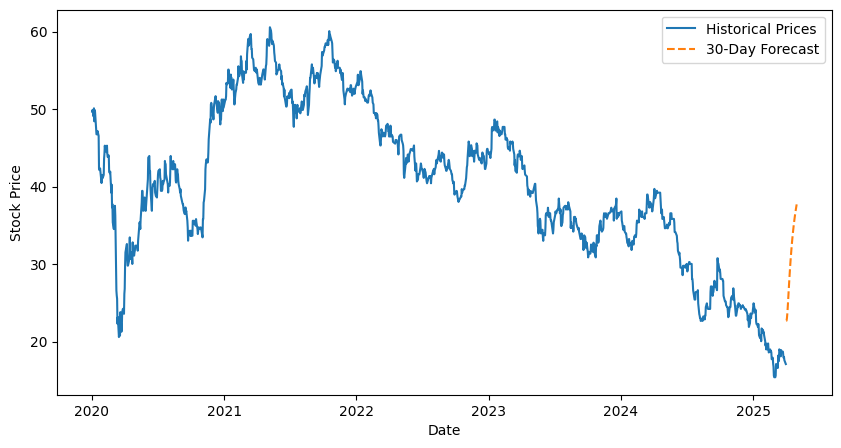

In [56]:
# Plot historical data and future predictions for comparison
plt.figure(figsize=(10, 5))
plt.plot(df['Close'], label='Historical Prices')
plt.plot(predictions_df, label='30-Day Forecast', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [92]:
# Step 7: Evaluationg model

# Make predictions on the test set
test_predictions = model.predict(x_test)

# Inverse transform the predictions to get them back to the original scale
test_predictions = scaler.inverse_transform(test_predictions)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

mse = mean_squared_error(y_test_rescaled, test_predictions)
mae = mean_absolute_error(y_test_rescaled, test_predictions)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_rescaled - test_predictions) / y_test_rescaled)) * 100

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 
Mean Absolute Error: 8.327432929285603
Root Mean Squared Error: 11.550927561145174
Mean Absolute Percentage Error (MAPE): 6.981642318056467%


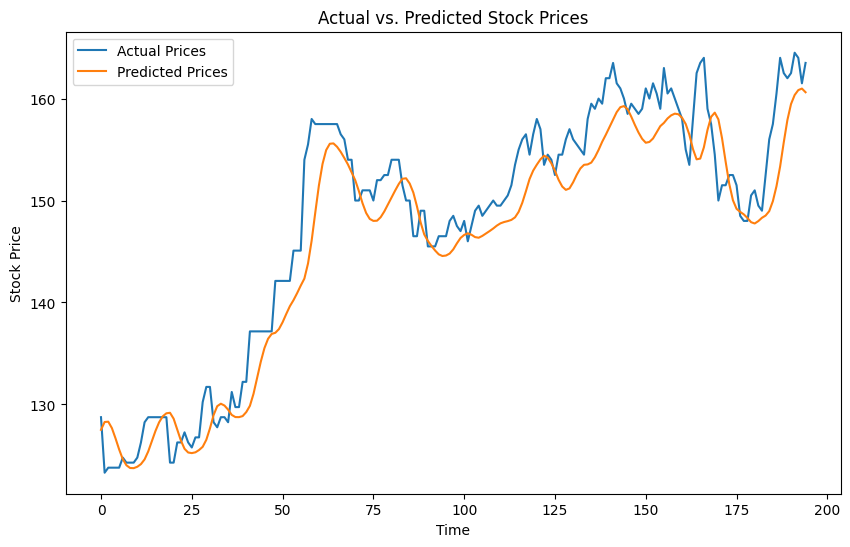

In [11]:
# Plot the actual vs. predicted prices
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual Prices')
plt.plot(test_predictions, label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Actual vs. Predicted Stock Prices')
plt.legend()
plt.show()